### Student Information
Name: 詹睿軒

Student ID: 113062543

GitHub ID: Big-problem

Kaggle name: BigProblem

Kaggle private scoreboard snapshot: 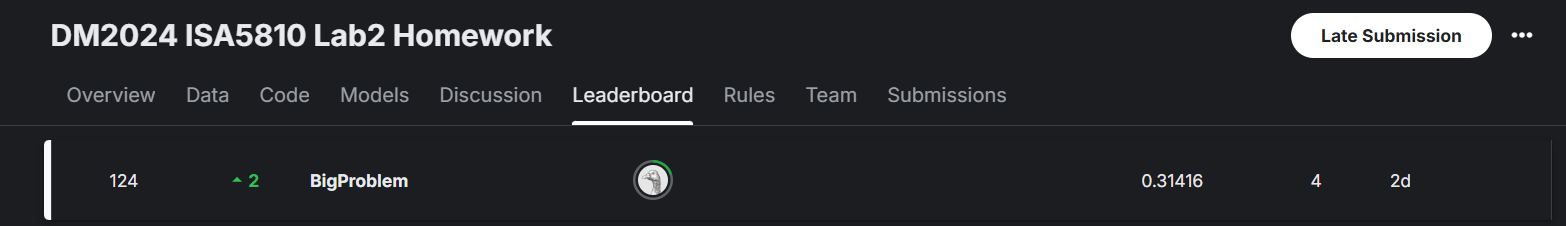

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

In [2]:
### Begin Assignment Here

In [ ]:
import json
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier

In [ ]:
data = []
with open('/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))

f.close()

In [ ]:
emotion = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/emotion.csv')
data_identification = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/data_identification.csv')

In [ ]:
emotion.groupby('emotion').count()

,tweet_id
emotion,
anger,39867
anticipation,248935
disgust,139101
fear,63999
joy,516017
sadness,193437
surprise,48729
trust,205478


In [ ]:
df = pd.DataFrame(data)
_source = df['_source'].apply(lambda x: x['tweet'])
df = pd.DataFrame({
    'tweet_id': _source.apply(lambda x: x['tweet_id']),
    'hashtags': _source.apply(lambda x: x['hashtags']),
    'text': _source.apply(lambda x: x['text']),
})
df = df.merge(data_identification, on='tweet_id', how='left')

train_data = df[df['identification'] == 'train']
test_data = df[df['identification'] == 'test']

In [ ]:
train_data = train_data.merge(emotion, on='tweet_id', how='left')

In [41]:
len(train_data)

1455563

In [42]:
train_data.drop_duplicates(subset=['text'], keep=False, inplace=True)

In [44]:
train_data_sample = train_data.sample(frac=0.3, random_state=99)

In [ ]:
y_train_data = train_data_sample['emotion']
X_train_data = train_data_sample.drop(['tweet_id', 'emotion', 'identification', 'hashtags'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train_data, y_train_data, test_size=0.3, random_state=99, stratify=y_train_data)

In [ ]:
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')  # 過濾英語停用詞

# 計算 TF-IDF
X = tfidf.fit_transform(X_train['text']).toarray()
X_test = tfidf.transform(X_test['text'])

feature_names = tfidf.get_feature_names_out()

# 計算每個詞的平均 TF-IDF 值
average_tfidf = np.mean(X, axis=0)
top_indices = np.argsort(average_tfidf)[-10:]  # 選擇平均值最高的 10 個詞
top_words = [feature_names[i] for i in top_indices]
print("平均 TF-IDF 最高的詞:", top_words)

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
# 訓練模型
model = XGBClassifier(n_estimators=400, max_depth=5, learning_rate=0.005, min_child_weight=2.5)
model.fit(X, y)

# 測試模型
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
X_test_data = test_data.drop(['tweet_id', 'identification', 'hashtags'], axis=1)

In [ ]:
X_test_data = tfidf.transform(X_test_data['text']).toarray()

In [ ]:
y_test_pred = model.predict(X_test_data)
y_pred_labels = le.inverse_transform(y_test_pred)
y_pred_labels

In [ ]:
submission = pd.DataFrame({
    'id': test_data['tweet_id'],
    'emotion': y_pred_labels
})

submission.to_csv('/kaggle/working/submission.csv', index=False)